# Exploratory analyses of the GEX data

---
This notebook implements a standard scRNA-seq processing pipeline using the previously filtered scRNA-seq data from U2OS cells from Mahdessian et al. (2021).

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

---

## 1. Read in data

We will now read in the preprocessed GEX data set.

In [2]:
adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
data = pd.DataFrame(
    adata.X, columns=adata.var_names, index=adata.obs_names
)
data.columns = [c.upper() for c in data.columns]
adata

AnnData object with n_obs × n_vars = 1126 × 21445
    obs: 'n_genes_per_cell', 'n_genes'
    var: 'gene_symbol', 'n_cells_per_gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensmbl_id'
    uns: 'hvg'

In [3]:
with open("../../../data/other/selected_orf_targets.txt") as f:
    orf_targets = set(f.read().split("\n")[:-1])

The data set consists of 1'126 cells with the expression for 21'445 genes. It has been filtered to exclude genes expressed in less than 10 different cells and cells expressing less than 8'000 genes. Additionally we duplicate genes after mapping the EnsembleID to the respective HGNC symbols.

---

## 2. Overview

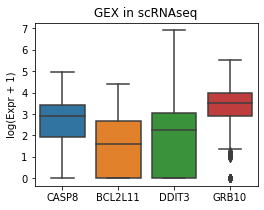

In [9]:
plt.figure(figsize=[4,3])
sns.boxplot(data=data.loc[:,["CASP8", "BCL2L11", "DDIT3", "GRB10"]])
plt.ylabel("log(Expr + 1)")
plt.title("GEX in scRNAseq")
plt.show()

First, we will look at the 20 highest and 20 lowest expressed genes in the data set.

In [10]:
median_expressions = data.median(axis=0).sort_values(ascending=False)
most_expressed_genes = list(median_expressions.head(20).index)
least_expressed_genes = list(median_expressions.tail(20).index)

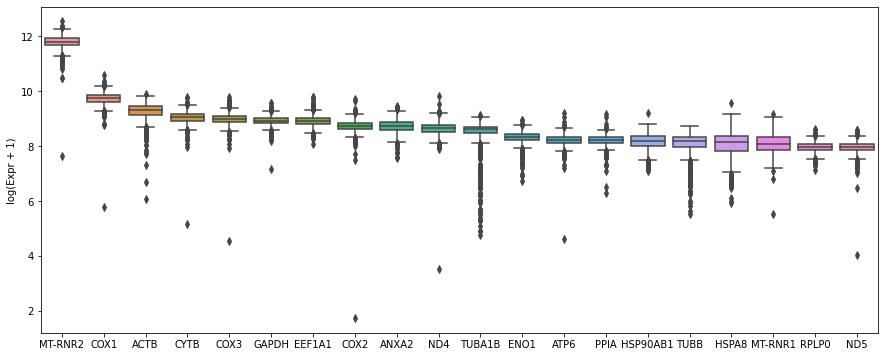

In [11]:
plt.figure(figsize=[15,6])
sns.boxplot(data=data.loc[:,most_expressed_genes])
plt.ylabel("log(Expr + 1)")
plt.show()

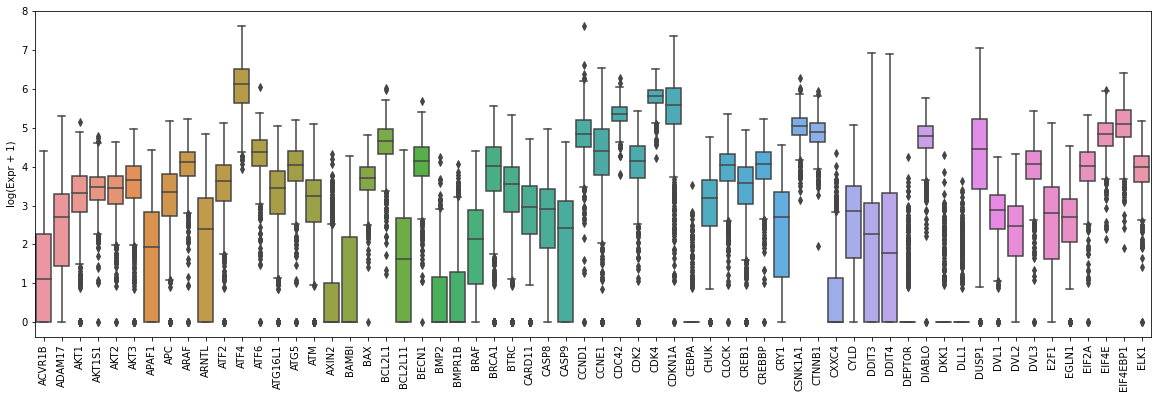

In [25]:
plt.figure(figsize=[20,6])
ax = sns.boxplot(data=data.loc[:,sorted(list(orf_targets))[:62]])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel("log(Expr + 1)")
plt.show()

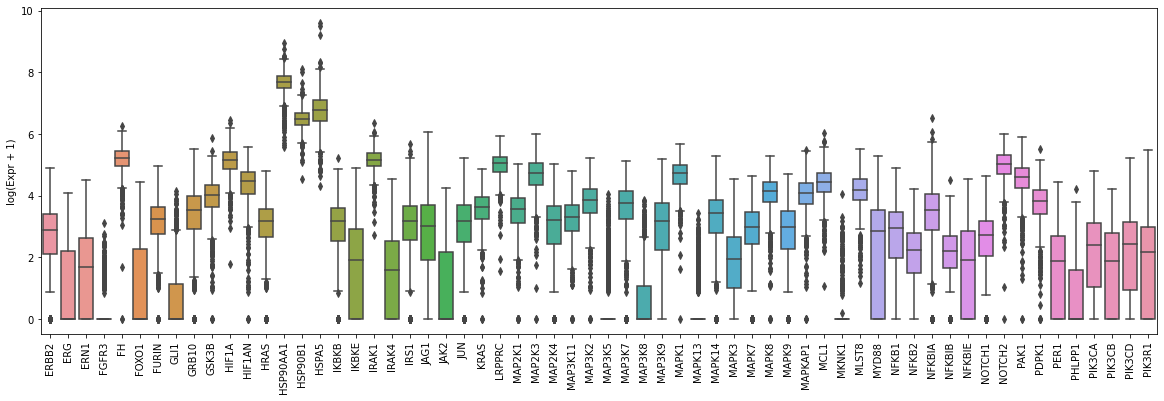

In [26]:
plt.figure(figsize=[20,6])
ax = sns.boxplot(data=data.loc[:,sorted(list(orf_targets))[62:124]])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel("log(Expr + 1)")
plt.show()

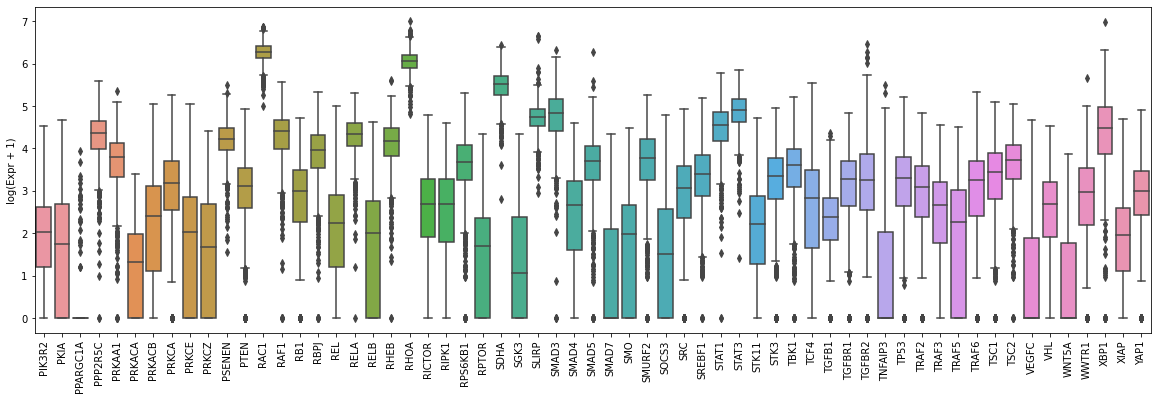

In [28]:
plt.figure(figsize=[20,6])
ax = sns.boxplot(data=data.loc[:,sorted(list(orf_targets))[124:]])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylabel("log(Expr + 1)")
plt.show()

In [35]:
results = pd.read_csv("/home/paysan_d/Desktop/ctrl_vs_single_target_results.csv").sort_values("test_acc", ascending=False)

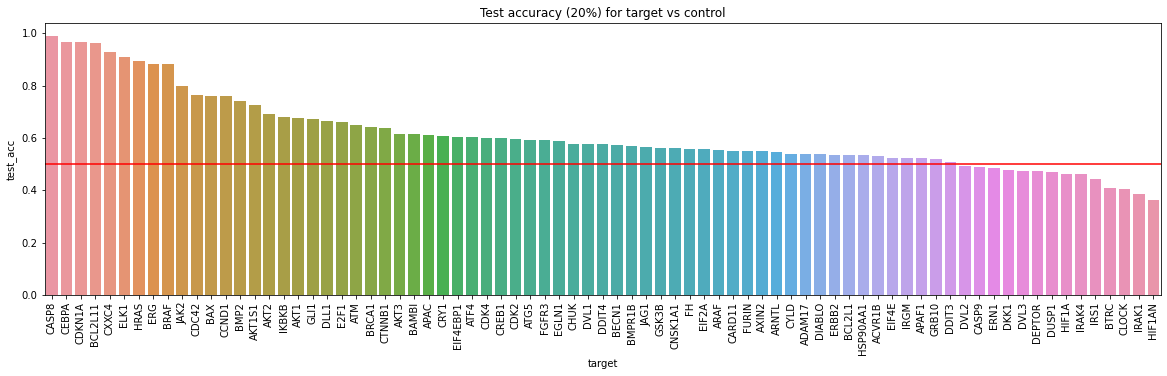

In [45]:
plt.figure(figsize=[20,5])
ax = sns.barplot(data=results,x="target", y="test_acc")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axhline(y=0.5, color="r")
plt.title("Test accuracy (20%) for target vs control")
plt.show()

We see that the most expressed genes are known to be involved in many inflammatory and cytokine signaling pathways but also include two mitochondrial genes MT-RNR1/2. The least expressed genes are all non-coding genes associated with the IncRNA class.

We will now compute the highly variable genes as described in Satija 2015.

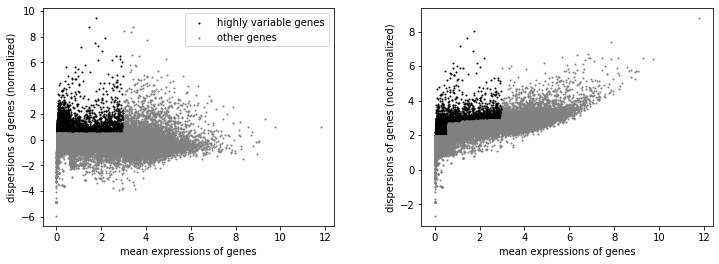

In [47]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [48]:
adata.raw = adata

---

## 3. Clustering

We will now investigate the heterogeneity in the population of U2OS in our data set. To this end, we will first reduce the dimensionality by focussing on the most variable genes and applying PCA and second clustered the lower-representation using Leiden clustering.

In [49]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

The above scree plot suggests a conservative choice of 15-20 components. We will use 20 for now.

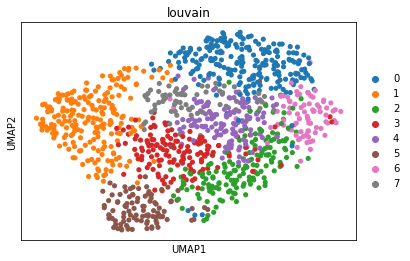

In [95]:
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)
sc.tl.louvain(adata)
sc.pl.umap(adata, color="louvain")

The above plots shows the cell population in the UMAP space computed on the first 20 principal components of the most variable genes. Since the whole population describes wildtype U2OS cells, the observed representation matches our expectation by showing limited heterogeneity within the population.